## Best subset linear regression problem

In [186]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [187]:
p = 200
K = p 
n = 60
p_sub = 3
noise = 1
lambda_ = 2.0

X = np.random.normal(size = (n,p))
beta = np.random.normal(size = p_sub)
y = np.matmul(X[:,:p_sub],beta) + np.random.normal(loc = 0.0, scale = noise, size = n)

In [188]:
t = [X,y,lambda_]

In [189]:
def f(z,t):
    X =t[0]
    y = t[1]
    lam = t[2]
    Xt = X[:,z==1]
    if z.sum() > 0:
        reg = LinearRegression().fit(Xt,y).predict(Xt)
    else:
        reg = np.zeros(y.shape[0])
    return ((y - reg)**2).mean() + lam*(z.sum())
    

In [190]:
def sampleDisARM(theta,f,t):
    u = np.random.uniform(size= K)
    #z = np.array([1.0 if u[j] < theta[j] else 0.0 for j in range(K)])
    #ztilde = np.array([1.0 if 1.0 - u[j] < theta[j] else 0.0 for j in range(K)])
    z = (u < theta).astype(int)
    ztilde = (1.0 - u < theta).astype(int)
    diff = f(z,t) - f(ztilde,t)
    
    g = np.zeros(K)
    g[theta < 0.5] = 0.5*diff*((-1)**(ztilde[theta<0.5]))*(1/theta[theta<0.5])
    g[theta >= 0.5] = 0.5*diff*((-1)**(ztilde[theta>=0.5]))*(1/(1.0 - theta[theta>=0.5]))
    g[ztilde == z] = 0 
    
    return g
    
def sampleBitFlip_1(theta,f,t):
    q = np.random.choice(list(range(K)))
    z = np.random.binomial(n=1, p = theta)
    g = np.zeros(K)
    z_copy = z.copy()
    z[q] = 1
    z_copy[q] = 0
    g[q] = K*(f(z,t) - f(z_copy,t))
    return g

def sampleBitFlip_k(theta, f,t):
    z = np.random.binomial(n=1, p = theta)
    g = np.zeros(K)
    
    for i in range(K):
        z_copy = z.copy()
        z_copy2 = z.copy()
        z_copy[i] = 1
        z_copy2[i] = 0
        g[i] = (f(z_copy,t) - f(z_copy2,t))
        
    return g


def sampleBitFlip_opt(theta,f,t):
    g_1 = sampleBitFlip_1(theta,f,t) #not comparing wall clock so this is ok
    g_2 = sampleDisARM(theta,f,t)
    use_bitflip = 1/np.min(np.array([theta,1-theta]), axis = 0) >= 3.0
    g = np.zeros(K)
    g[use_bitflip] = g_1[use_bitflip]
    g[~use_bitflip] = g_2[~use_bitflip]
    return g


def sampleReinforce_loo(theta,f,t):
    z1 = np.random.binomial(n=1, p = theta)
    z2 = np.random.binomial(n=1, p = theta)
    f1 = f(z1,t)
    f2 = f(z2,t)
    return 0.5 * ((f1 - f2) * (z1 - theta)+ (f2 - f1) * (z2 - theta)) *(1/theta)*(1/(1-theta))
def loss(theta, t,K):
    """ 
    K is monte carlo samples 
    """
    loss = 0
    for k in range(K):
        z = np.random.binomial(n=1, p = theta)
        loss = loss + f(z,t)

    return loss/K

In [325]:
def sigma(x):
    return np.exp(x)/(1+np.exp(x))

def train(grad_func,start, t, n_epoch = 1000, learning_rate = 5.0):
    
    losses = []
    thetas = []
    vars_ = []
    phi = start
    
    for i in tqdm(range(n_epoch)):
        theta = sigma(phi)
        g = grad_func(theta, f, t)
        
        #compute variances:
        g_ss = []
        for j in range(10):
            g_s = grad_func(theta, f, t)
            g_ss.append(g_s)
        g_ss = np.array(g_ss)
        vars_.append(np.var(g_ss, axis = 0).mean())
        
            
        phi = phi - learning_rate*g*sigma(phi)*sigma(-1.0*phi)
        
        thetas.append(theta)
        losses.append(loss(theta,t, 100))
    return thetas,losses, np.array(vars_)

def train2(grad_func,start, t, n_epoch = 1000, learning_rate = 0.1):
    
    losses = []
    thetas = []
    vars_ = []
    theta = start
    
    for i in tqdm(range(n_epoch)):
        theta[theta < 0] = 10e-12
        theta[theta > 1] = 1 - 10e-12
        g = grad_func(theta, f, t)
        
        #compute variances:
        g_ss = []
        for j in range(5):
            g_s = grad_func(theta, f, t)
            g_ss.append(g_s)
        g_ss = np.array(g_ss)
        vars_.append(np.var(g_ss, axis = 0).mean())
        
            
        theta = theta - learning_rate*g#*sigma(phi)*sigma(-1.0*phi)
        
        theta[theta < 0] = 10e-12
        theta[theta > 1] = 1 - 10e-12
        thetas.append(theta)
        losses.append(loss(theta,t, 100))
    return thetas,losses, np.array(vars_)

## Train

In [192]:
p = 200
K = p 
n = 60
p_sub = 3
noise = 0.5
lambda_ = 2.0

X = np.random.normal(size = (n,p))
beta = np.random.normal(size = p_sub)
y = np.matmul(X[:,:p_sub],beta) + np.random.normal(loc = 0.0, scale = noise, size = n)

In [193]:
start = np.array([0.1]*p)

In [194]:
#thetas_d, losses_d, vars_d = train(sampleDisARM, start = start, t = t,  n_epoch = 1000, learning_rate = 1.0)

In [195]:
l_r = []
l_d = []
l_b = []
l_o = []

v_r = []
v_d = []
v_b = []
v_o = []

for i in range(10):
    
    X = np.random.normal(size = (n,p))
    beta = np.random.normal(size = p_sub)
    y = np.matmul(X[:,:p_sub],beta) + np.random.normal(loc = 0.0, scale = noise, size = n)
    t = [X,y,lambda_]
    thetas_r, losses_r, vars_r = train(sampleReinforce_loo, start = start, t=t, n_epoch = 1000, learning_rate = 1.0)
    thetas_d, losses_d, vars_d = train(sampleDisARM, start = start, t = t,  n_epoch = 1000, learning_rate = 1.0)
    thetas_b, losses_b, vars_b = train(sampleBitFlip_1, start = start, t = t,  n_epoch = 1000, learning_rate = 1.0)
    thetas_o, losses_o, vars_o = train(sampleBitFlip_opt, start = start, t=t,  n_epoch = 1000, learning_rate = 1.0)
    
    l_r.append(losses_r)
    l_d.append(losses_d)
    l_b.append(losses_b)
    l_o.append(losses_o)

    v_r.append(vars_r)
    v_d.append(vars_d)
    v_b.append(vars_b)
    v_o.append(vars_o)


 77%|███████▋  | 768/1000 [01:09<00:21, 11.03it/s]


KeyboardInterrupt: 

In [161]:
SNR = (beta**2).sum()/noise**2

In [162]:
SNR

3.255174967438127

In [163]:
l_r = np.array(l_r)
l_d = np.array(l_d)
l_b = np.array(l_b)
l_o = np.array(l_o)

v_r = np.array(v_r)
v_d = np.array(v_d)
v_b = np.array(v_b)
v_o = np.array(v_o)

In [164]:

with open('l_r_2.npy', 'wb') as f:
    np.save(f, l_r)

with open('l_d_2.npy', 'wb') as f:
    np.save(f, l_d)
    
with open('l_b_2.npy', 'wb') as f:
    np.save(f, l_b)
    
with open('l_o_2.npy', 'wb') as f:
    np.save(f, l_o)
    
with open('v_r_2.npy', 'wb') as f:
    np.save(f, v_r)
    
with open('v_d_2.npy', 'wb') as f:
    np.save(f, v_d)

with open('v_b_2.npy', 'wb') as f:
    np.save(f, v_b)
    
with open('v_o_2.npy', 'wb') as f:
    np.save(f, v_o)
    


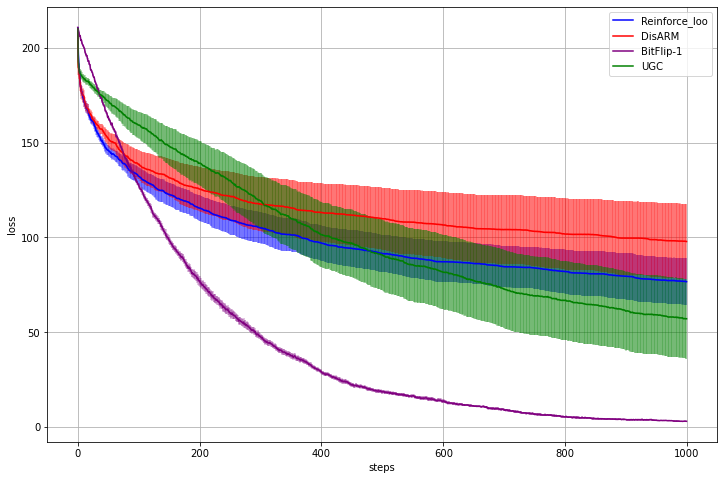

In [165]:
plt.figure(figsize = (12,8))
plt.errorbar(list(range(l_r.shape[1])),l_r.mean(axis = 0), l_r.std(axis = 0)/np.sqrt(10), alpha = 0.3, color = "blue")
plt.plot(l_r.mean(axis = 0), color = "blue", label = "Reinforce_loo")
plt.errorbar(list(range(l_d.shape[1])),l_d.mean(axis = 0), l_d.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "red")
plt.plot(l_d.mean(axis = 0), color = "red", label = "DisARM")
plt.errorbar(list(range(l_b.shape[1])),l_b.mean(axis = 0), l_b.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "purple")
plt.plot(l_b.mean(axis = 0), label = "BitFlip-1", color = "purple")
plt.errorbar(list(range(l_o.shape[1])),l_o.mean(axis = 0), l_o.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "green")
plt.plot(l_o.mean(axis = 0), label = "UGC", color = "green")
plt.ylabel("loss")
plt.xlabel("steps")
#plt.axhline(K*(t_**2), c = "black", linestyle ="--", label = "opt")
plt.legend()
plt.grid()
plt.savefig("linear_regression_error_bars_2.png", dpi = 300)

In [172]:
beta

array([-1.2891536 ,  0.83873372, -0.94328347])

In [166]:
N = 500
v_r[v_r > 10000] = 10000
v_d[v_d > 10000] = 10000
v_b[v_b > 10000] = 10000
v_o[v_o > 10000] = 10000
v_r_new = np.convolve(v_r.mean(axis = 0), np.ones(N)/N, mode='valid')
v_d_new = np.convolve(v_d.mean(axis = 0), np.ones(N)/N, mode='valid')
v_b_new = np.convolve(v_b.mean(axis = 0), np.ones(N)/N, mode='valid')
v_o_new = np.convolve(v_o.mean(axis = 0), np.ones(N)/N, mode='valid')

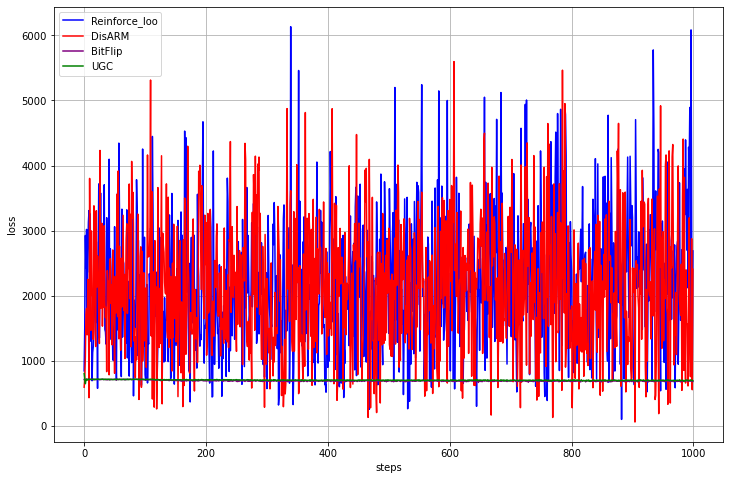

In [167]:
plt.figure(figsize = (12,8))
plt.plot(v_r.mean(axis = 0), label = "Reinforce_loo", color = "blue")
plt.plot(v_d.mean(axis = 0), label = "DisARM", color = "red")
plt.plot(v_b.mean(axis = 0), label = "BitFlip", color = "purple")
plt.plot(v_o.mean(axis = 0), label = "UGC", color = "green")
plt.ylabel("loss")
plt.xlabel("steps")
#plt.axhline(K*(t_**2), c = "black", linestyle ="--", label = "opt")
plt.legend()
plt.grid()
plt.savefig("linear_regression_variances_2.png", dpi = 300)

In [333]:
p = 200
K = p 
n = 60
p_sub = 3
noise = 1
lambda_ = 1

In [334]:
X.shape

(60, 200)

In [335]:
X = np.random.normal(size = (n,p))
start = np.array([0.1]*p)
beta = np.array([3,2,1.5])
y = np.matmul(X[:,:p_sub],beta) + np.random.normal(loc = 0.0, scale = noise, size = n)
t = [X,y,lambda_]
thetas_r, losses_r, vars_r = train2(sampleReinforce_loo, start = start, t=t, n_epoch = 2000, learning_rate = 0.01)
thetas_d, losses_d, vars_d = train2(sampleDisARM, start = start, t = t,  n_epoch = 2000, learning_rate = 0.01)
thetas_b, losses_b, vars_b = train2(sampleBitFlip_1, start = start, t = t,  n_epoch = 2000, learning_rate = 0.01)
thetas_o, losses_o, vars_o = train2(sampleBitFlip_opt, start = start, t=t,  n_epoch = 2000, learning_rate = 0.01)


100%|██████████| 2000/2000 [01:45<00:00, 18.99it/s]


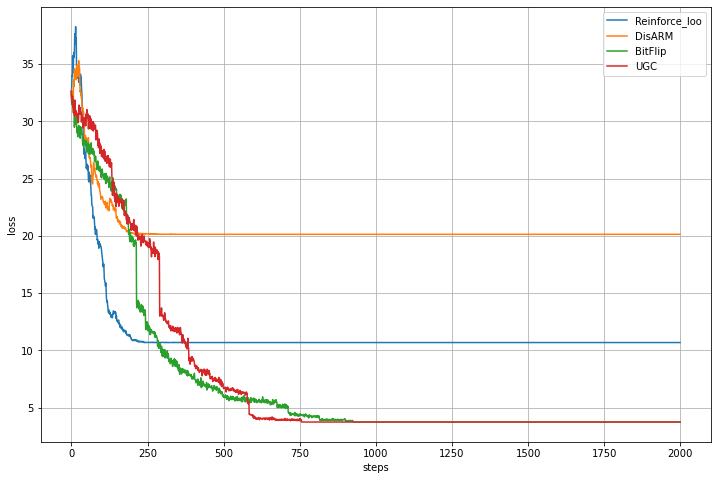

In [337]:
plt.figure(figsize = (12,8))
plt.plot(losses_r, label = "Reinforce_loo")
plt.plot(losses_d, label = "DisARM")
plt.plot(losses_b, label = "BitFlip")
plt.plot(losses_o, label = "UGC")
plt.ylabel("loss")
plt.xlabel("steps")
#plt.axhline(K*(t_**2), c = "black", linestyle ="--", label = "opt")
plt.legend()
plt.grid()
plt.show()

In [338]:
loss(thetas_b[-1],t,100)

3.7590626924496338

In [339]:
(y**2).mean()

20.593154650310574

In [340]:
thetas_b[-1]

array([1.e+00, 1.e+00, 1.e+00, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
      